In [482]:
#* Import and settings
import os
from os import path
import re

import numpy as np
from scipy.optimize import curve_fit
import sympy as sp
from sympy import Symbol as s
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from lab_tools import graph, lab_round

%matplotlib widget

width = 469.75502 # To get the page width insert "\the\textwidth" in your LaTeX document
graph_path = "../images/"
data_path = "../data/"

mpl.rcParams.update({
    # Show minor ticks
    "ytick.minor.visible": True,
    "xtick.minor.visible": True,
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # High resolution .png
    "savefig.dpi": 600,
    # Default image size
    "figure.figsize": graph.size(width),
})

### Variables

In [483]:
WAVE_LENGTH = 650 / 10**9

SLIT = 0.02 / 10**3 # 0.02 | 0.04 | 0.08
SLIT_POSITION = 4 / 10**2

SENSOR_SLIT = 1.5 / 10**3 # 0.5 | 1.0 | 1.5
SENSOR_POSITION = 102.5 / 10**2

distance = SENSOR_POSITION - SLIT_POSITION


### Simulation

In [484]:
I_y_expr = s('I_0') * sp.Pow(
    sp.sinc(
        sp.pi * s('a') / s(r'\lambda') * s('y') / s('L')
    ), 2
)

display(sp.Eq(
    s(r'I(y)'), I_y_expr
))

Eq(I(y), I_0*sinc(pi*a*y/(L*\lambda))**2)

In [485]:
def get_I_y(I_0, a=SLIT, l=WAVE_LENGTH, L=distance):
    return sp.lambdify(
        [s('y')],
        I_y_expr.subs({
            s('I_0'): I_0,
            s('a'): a,
            s(r'\lambda'): l,
            s('L'): L,
        })
    )


Text(0, 0.5, 'I')

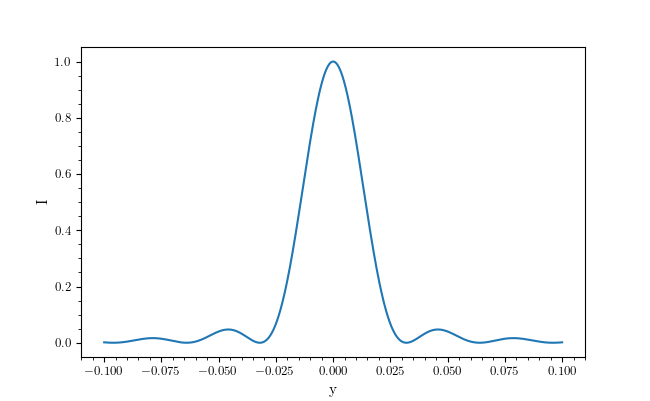

In [486]:
x = np.linspace(-0.1, 0.1, 1000)
I_y = get_I_y(1)

fig, ax = plt.subplots(1, 1)
ax.plot(x, I_y(x))

ax.set_xlabel("y")
ax.set_ylabel("I")

### Data

In [487]:
file_list = [
    file
    for file in os.listdir(data_path)
    if re.search(f"{SLIT * 10**3:.2f}_{SENSOR_SLIT * 10**3:.1f}_[\\d]+_[\\w]", file)
]

df_list = [
    pd.read_csv(
        path.join(data_path, file),
        sep=r"\t",
        engine="python",
    ) for file in file_list
]

n_set = len(df_list)

file_list

['0.02_1.5_100_An.tsv',
 '0.02_1.5_100_Ar.tsv',
 '0.02_1.5_100_Fl.tsv',
 '0.02_1.5_100_VA.tsv']

Make minimum position $y = 0$

In [488]:
for df in df_list:
    df.y -= np.min(df.y)

Split each set in 2 and make each new set start from 0 and growing

In [489]:
df_list_split = []

for df in df_list:
    max_y_index = np.argmin(df.y)

    df_list_split.append(df[max_y_index::-1].reset_index(drop=True))
    df_list_split.append(df[max_y_index:].reset_index(drop=True))

df_list = df_list_split

for df in df_list:
    df.sort_values('y', inplace = True)
    df.reset_index(drop=True)

n_set = len(df_list)

# debug
# for i, df in enumerate(df_list):
#     print(f"Set {i + 1}")
#     print(df.head())
#     print()

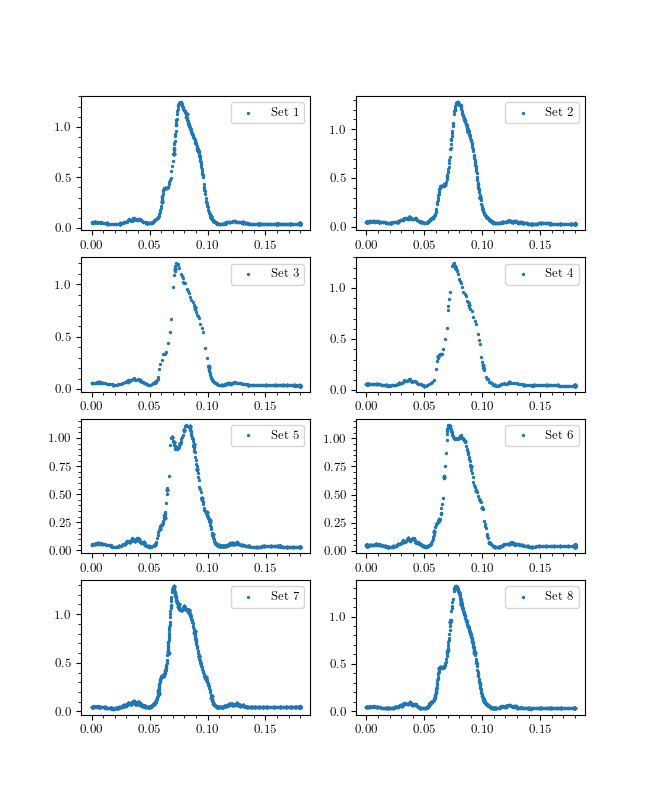

In [490]:
fig, axs = plt.subplots(n_set // 2, 2, figsize = graph.size(width, subplots=(n_set // 2, 2)))
axs = axs.flatten()

for i, df in enumerate(df_list):
    ax = axs[i]
    ax.scatter(df.y, df.I, s=2, label=f"Set {i + 1}")
    ax.legend()

# Compare data and simulation

In [491]:
peak_index_list = [np.argmax(df.I) for df in df_list]
peak_y_list = [df.y[i] for i, df in zip(peak_index_list, df_list)]
shift = np.mean(peak_y_list)
shift

0.0755030415100792

For SLIT $= 0.08$ (better peak) shift $= 0.08142071170739353$

In [492]:
shift = 0.081

for df in df_list:
    df.y -= shift

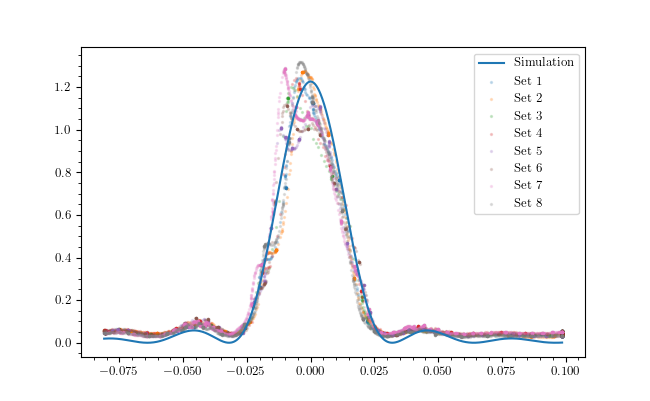

In [493]:
x = np.linspace(
    np.min([
        np.min(df.y) for df in df_list
    ]),
    np.max([
        np.max(df.y) for df in df_list
    ]),
    1000
)

I_y = get_I_y(
    np.mean([
        np.max(df.I) for df in df_list
    ])
)

fig, ax = plt.subplots(1, 1)

ax.plot(x, I_y(x), label="Simulation", alpha=1)

for i, df in enumerate(df_list):
    ax.scatter(df.y, df.I, s=2, label=f"Set {i + 1}", alpha=0.2)

ax.legend()

# Calculate $\lambda$

### Via fit

In [494]:
a_opt_list = []
a_var_list = []

for i, df in enumerate(df_list):
    max_I = np.max(df.I)

    I_y_fit_a = sp.lambdify(
        [s('y'), s('a')],
        I_y_expr.subs({
            s('I_0'): max_I,
            s(r'\lambda'): WAVE_LENGTH,
            s('L'): distance,
        })
    )

    (a_opt, ), ((a_var, ), ) = curve_fit(I_y_fit_a, df.y, df.I, [SLIT])

    a_opt_list.append(a_opt)
    a_var_list.append(a_var)

    # debug
    print(f"a (set {i + 1}) = {a_opt * 10**3:.5f} +/- {np.sqrt(a_var) * 10**3:.5f} mm")
    # x = np.linspace(np.min(df.y), np.max(df.y), 1000)
    # fig, ax = plt.subplots(1, 1)
    # ax.plot(x, I_y_fit_a(x, a_opt))
    # ax.scatter(df.y, df.I, s=2)


a_weight_list = [1 / a_var for a_var in a_var_list]

a_avg = np.average(a_opt_list, weights=a_weight_list)
a_sig = 1 / np.sqrt(sum(a_weight_list))
print(f"\na = {a_avg * 10**3:.5f} +/- {a_sig * 10**3:.5f} mm")

a (set 1) = 0.02168 +/- 0.00011 mm
a (set 2) = 0.02320 +/- 0.00010 mm
a (set 3) = 0.02048 +/- 0.00021 mm
a (set 4) = 0.02122 +/- 0.00017 mm
a (set 5) = 0.01957 +/- 0.00009 mm
a (set 6) = 0.01944 +/- 0.00012 mm
a (set 7) = 0.01974 +/- 0.00012 mm
a (set 8) = 0.02286 +/- 0.00012 mm

a = 0.02110 +/- 0.00004 mm


### Find minimum points in data

In [495]:
dy_between_min = WAVE_LENGTH * distance / a_avg

min_y_lists = []

for df in df_list:
    min_y_list = []

    for inf_lim in np.arange(- dy_between_min * (2 + 1/2), dy_between_min * (2 + 1/4), dy_between_min):
        sup_lim = inf_lim + dy_between_min

        if inf_lim < 0 and sup_lim > 0:
            continue

        df_mask = df.y.between(inf_lim, sup_lim)

        if not any(df_mask):
            continue
        
        df_slice = df[df_mask].reset_index(drop=True)
        
        min_y_list.append(df_slice.iloc[df_slice.idxmin().I].y)

    min_y_lists.append(min_y_list)

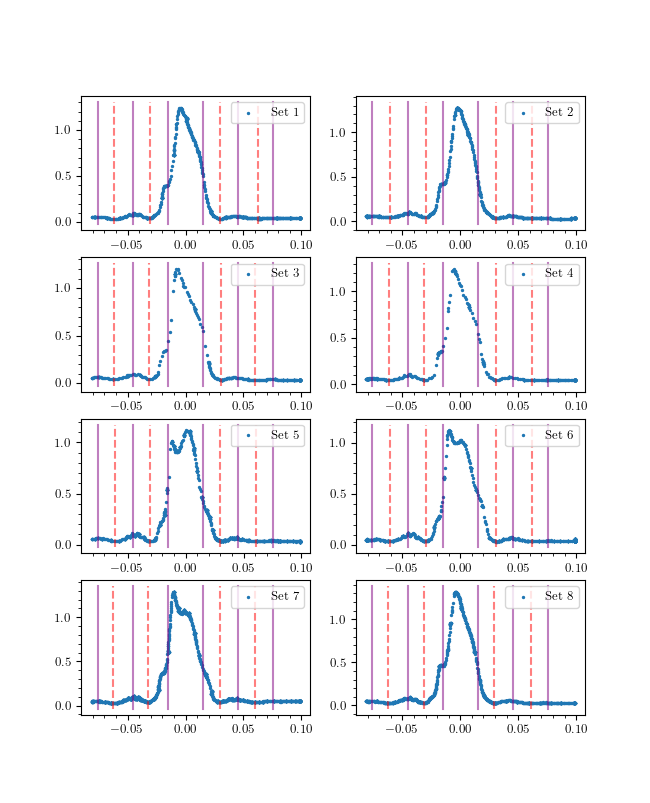

In [496]:
fig, axs = plt.subplots(n_set // 2, 2, figsize = graph.size(width, subplots=(n_set // 2, 2)))
axs = axs.flatten()

for i, df in enumerate(df_list):
    ax = axs[i]
    ax.scatter(df.y, df.I, s=2, label=f"Set {i + 1}")
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    for y in min_y_lists[i]:
        ax.plot([y, y], y_lim, '--', color='red', alpha=0.5)
    for lim in np.arange(- dy_between_min * (2 + 1/2), dy_between_min * 3, dy_between_min):
        ax.plot([lim, lim], y_lim, color='purple', alpha = 0.5)
    
    ax.set_xlim(x_lim)
    ax.legend()